<a href="https://colab.research.google.com/github/Mgt-A/fastai-v3/blob/master/Wintersports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Classification of winter sports images

---

## Binary classification

### Introduction

In this notebook, we'll try to train a neural network to detect images of skiers and snowboarders. The notebook will cover everything from the creation of the dataset to the implementation of the neural network and hopefully, its commissioning using a web app.

We'll do so using the fast ai library as well as a dataset from google images.

In [0]:
from fastai.vision import *
from fastai import *

You can use Google Colab for free GPU usage by running this piece of code at the beginning of your notebook :

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Wintersports'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Dataset creation

#### Find images

First of all we need to find images to create our dataset. Go on google images and look for "skier" and "snowboarder" then scroll down until you have a satisfying amount of images. Remember that the more images your network sees, the better the result will likely be.

#### Download images' links

Once we've got a satifysing amount of images displayed on your google images page, we will use a small piece of javascript code to obtain the link to all of them at once :

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

From there, download the file containing the link to all of your images. Save it as `skier_urls.txt` (`snowboarder_urls.txt` respectively) in a folder of your choice.

#### Upload images



In [0]:
folders = ['binary/skier', 'binary/snowboarder'] # Putting them into a sub-folder named binary for later use.
files = ['skier_urls.csv', 'snowboarder_urls.csv']

In [0]:
from pathlib import Path
import os

# Get current directory
p = Path(base_dir)

Download all your images in the desired folder using fastai's `download_images` function :

In [0]:
for fold, file in zip(folders, files):
  dest = p/fold
  dest.mkdir(parents=True, exist_ok=True)
  
  download_images(p/file, dest)

Verify that all images can be opened correctly and delete those that can't :

In [0]:
for c in folders:
    print(c)
    verify_images(p/c, delete=True)

I have also manually erased some pictures from my dataset because the label was not really representative of the picture. Also, I tried my best to remove pictures that contain more than one person.

You can play with google search's parameters to get result as clean as possible but you will most likely still have to go through your data to make sure that they are good enough to be used. For my example sadly, by typing "skier" on google images, you can still expect to find pictures of snowboarders, we absolutely want to avoid using that kind of data for our training.

Fast AI has a widget that allows you to delete the training images that produces the biggest training loss however, Google Colab does not allow the usage of widget so I manually erased those that I expected to produce the biggest loss.

#### Train/valid set generation

After your data is clean, you can create a databunnch that contains your training set with your selected parameters. I chose to squish images instead of crop because a lot my images were uncentered an cropping sometimes made the subject of the image disappear.

In [0]:
np.random.seed(0)
data = ImageDataBunch.from_folder(p/"binary", train=".", valid_pct=0.2, size=224, resize_method=ResizeMethod.SQUISH, num_workers=4, padding_mode = 'zeros').normalize(imagenet_stats)

In [19]:
data.classes

['skier', 'snowboarder']

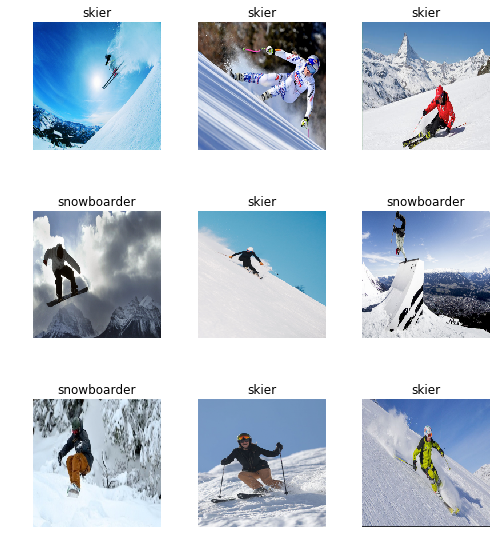

In [20]:
data.show_batch(rows=3, figsize=(7,8))

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['skier', 'snowboarder'], 2, 328, 81)

### Fitting a neural network

We will use a pre-trained **resnet50** architecture to learn to recognize snowboarders from skiers.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Training the last layers :

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.686738,0.809954,0.345679,00:19
1,0.456905,0.490263,0.172840,00:19
2,0.317736,0.367203,0.135802,00:19
3,0.242178,0.337477,0.148148,00:19


In [0]:
learn.save('binary-1')

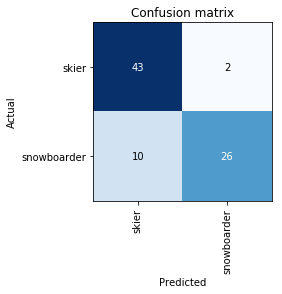

In [25]:
interpretation = ClassificationInterpretation.from_learner(learn)

interpretation.plot_confusion_matrix()

Our results are already pretty good but let's try to see if we can improve them.

We unfreeze the weights of our neural networkds and try to look for the better learning rate for some additional fitting :


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


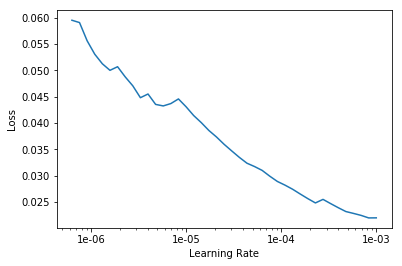

In [26]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, slice(1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.040947,0.322930,0.148148,00:19
1,0.039226,0.319537,0.148148,00:20


In [0]:
learn.save('binary-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


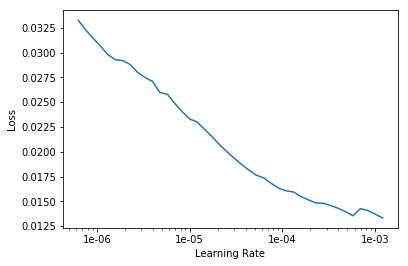

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(2, slice(2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.030698,0.316158,0.148148,00:18
1,0.033894,0.315200,0.148148,00:19


In [31]:
learn.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.028894,0.300712,0.148148,00:18
1,0.024175,0.290515,0.148148,00:19


In [32]:
learn.fit_one_cycle(2, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.012531,0.254459,0.111111,00:19
1,0.010029,0.226740,0.098765,00:19


We were probably too conservative with our learning rate...

In [0]:
learn.save('binary-3')

In [41]:
learn.load('binary-3')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

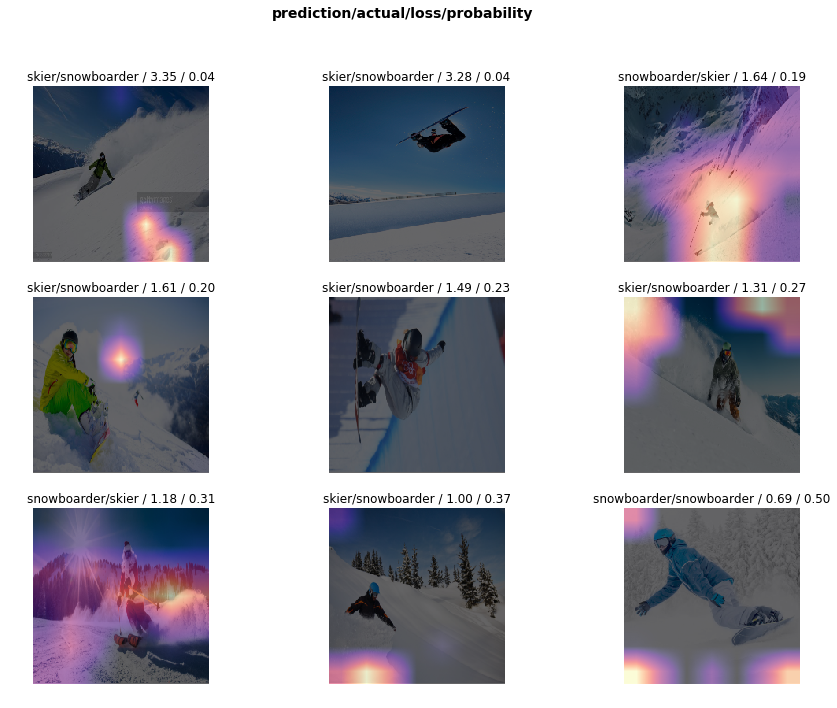

In [42]:
interp.plot_top_losses(9, figsize=(15,11))

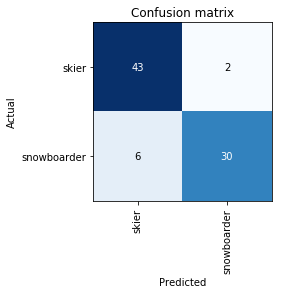

In [43]:
interp.plot_confusion_matrix()

In [0]:
learn.export('wintersports-binary-model')

In [0]:
defaults.device = torch.device('cpu')

In [0]:
import time

In [0]:
folder = root_dir + 'Test ski'

for file in os.listdir(folder):
  img = open_image(Path(folder + '/' + file))
  img.show(figsize=(6,6), title=file);
  pred_class,pred_idx,outputs = learn.predict(img)
  print("I am {} % sure that {} is a picture of a {}".format(round(float(max(outputs))*100, 2), file, pred_class))
  

## Making it Multiclass

To spice things up I decided to add 3 more classes to our dataset, to turn my binary classification task in to a multiclass classification task.

I added picture of monoskiers, ski-jumpers and cross-country skiers to my dataset. I was particularly curious to see what would be the network's ability to classify monoskiers as they have a skier's posture and use ski sticks while their board resemble that of a snowboarder. Other than that I expected the network to be able to classify ski jumpers very easily as they have such a singular position.

### Images upload

Just repreat the previous step to download your new images

In [0]:
folders = ['cross-country', 'ski-jump', 'monoski']
files = ['crosscountryskier_urls.csv', 'skijumper_urls.csv', 'monoskier_urls.csv']

In [0]:
for fold, file in zip(folders, files):
  dest = p/fold
  dest.mkdir(parents=True, exist_ok=True)
  
  download_images(p/file, dest)

In [0]:
for c in folders:
    print(c)
    verify_images(p/c, delete=True)

### Train/valid set generation

Fastai's tool will uatomatically separate skiers and snowboarders, even is they are in my binary folder, at the same level as the other classes.

In [0]:
np.random.seed(42)
data5 = ImageDataBunch.from_folder(p, train=".", valid_pct=0.2, size=224, resize_method=ResizeMethod.SQUISH, num_workers=4, padding_mode = 'zeros').normalize(imagenet_stats)

In [46]:
data5.classes

['cross-country', 'monoski', 'ski-jump', 'skier', 'snowboarder']

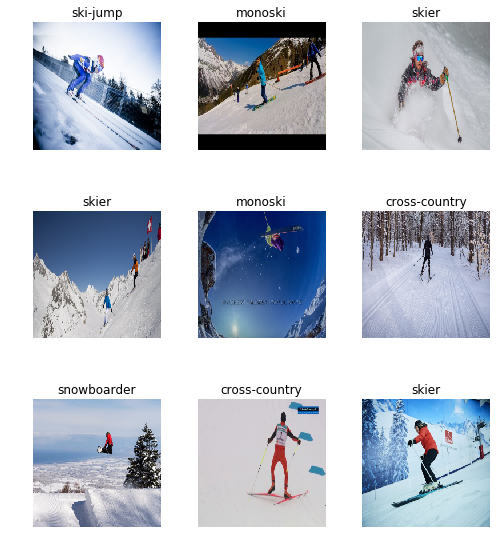

In [47]:
data5.show_batch(rows=3, figsize=(7,8))

In [48]:
data5.classes, data5.c, len(data5.train_ds), len(data5.valid_ds)

(['cross-country', 'monoski', 'ski-jump', 'skier', 'snowboarder'], 5, 644, 160)

### Fitting the model

In that part we repeart the same step as before but with a new classification task

In [0]:
learn5 = cnn_learner(data5, models.resnet50, metrics=error_rate)

In [50]:
learn5.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.413505,1.052957,0.393750,01:04
1,0.883693,0.707036,0.281250,00:33
2,0.599145,0.736846,0.262500,00:33
3,0.440656,0.712273,0.268750,00:34


In [0]:
learn5.save('multiclass-1')

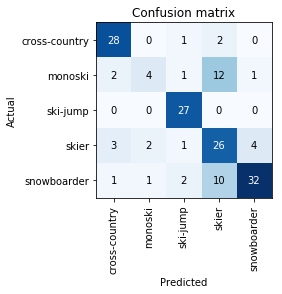

In [52]:
interpretation5 = ClassificationInterpretation.from_learner(learn5)

interpretation5.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


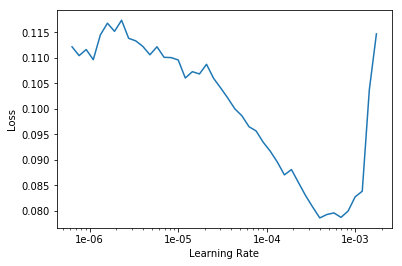

In [53]:
learn5.unfreeze()

learn5.lr_find()
learn5.recorder.plot()

In [54]:
learn5.fit_one_cycle(2, slice(3e-5))
learn5.save('multiclass-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.130572,0.708533,0.262500,00:34
1,0.120217,0.696266,0.256250,00:34


In [55]:
learn5.fit_one_cycle(2, slice(3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.086962,0.680548,0.250000,00:34
1,0.081663,0.674318,0.243750,00:34


In [0]:
learn5.save('multiclass-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


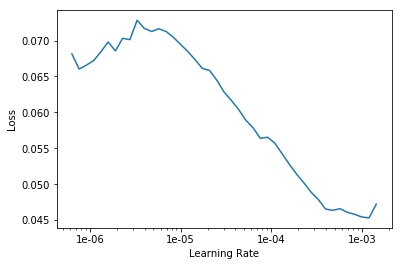

In [57]:
learn5.lr_find()
learn5.recorder.plot()

In [58]:
learn5.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.080919,0.658404,0.243750,00:33
1,0.061456,0.642755,0.237500,00:33


In [0]:
learn5.save('multiclass-4')

In [60]:
learn5.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.049723,0.634595,0.243750,00:33
1,0.044943,0.627923,0.256250,00:33


Here more fitting does not seem to improve classification so we'll stop there

In [61]:
learn5.load('multiclass-4')

interp5 = ClassificationInterpretation.from_learner(learn5)

losses5,idxs5 = interp5.top_losses()

len(data5.valid_ds)==len(losses5)==len(idxs5)

True

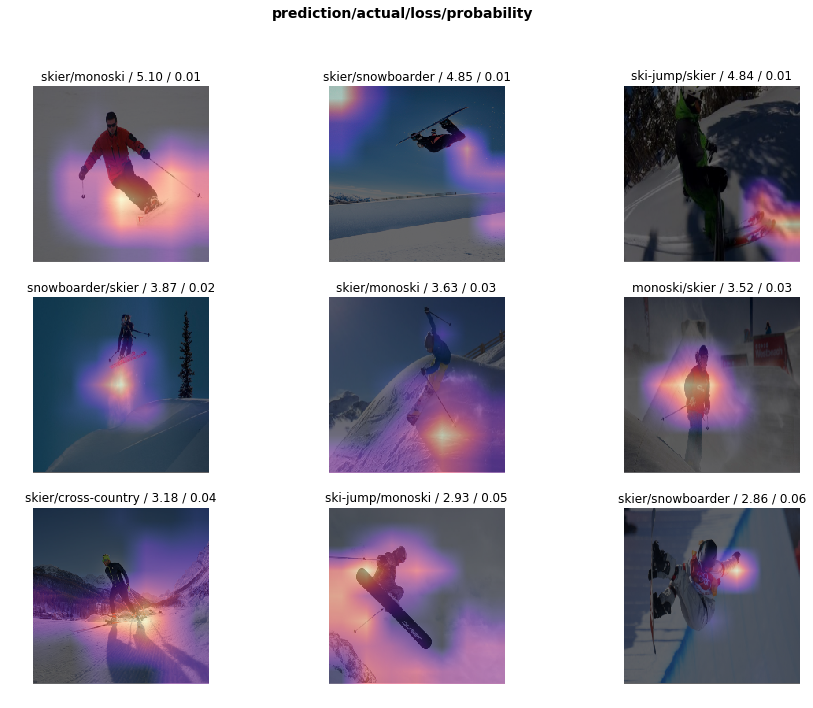

In [62]:
interp5.plot_top_losses(9, figsize=(15,11))

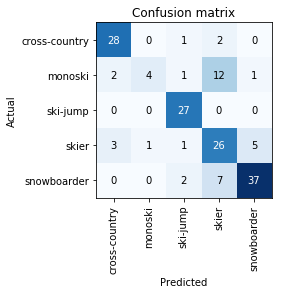

In [63]:
interp5.plot_confusion_matrix()

In [81]:
interp5.most_confused(3)

[('monoski', 'skier', 12),
 ('snowboarder', 'skier', 7),
 ('skier', 'snowboarder', 5),
 ('skier', 'cross-country', 3)]

As expected, our network has a hard time classifying the monoskiers. But we can observe that there are more confusion between skiers and snowboarders than there was in the previous binary classification model. Maybe our second model could benefit from the knowledge aquired by the first ?

## Using transfer learning to improve multiclass classification

In order to see what the knowledge of the first model can bring to the multiclass classification problem, we create a new pretrained model but feed it with the weights of our first model (expect for the last layers, as it does not contain the same number of neurons) and proceed as usually

In [0]:
learn5_2 = cnn_learner(data5, models.resnet50, metrics=error_rate)

In [65]:
learn5_2.model[0].load_state_dict(learn.model[0].state_dict())

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
learn5_2.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


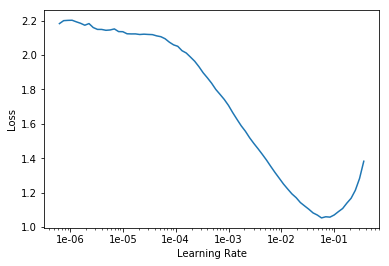

In [67]:
learn5_2.lr_find()
learn5_2.recorder.plot()

In [68]:
learn5_2.fit_one_cycle(4, slice(1e-3))
learn5_2.save('multiclass-transfer-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.714839,0.976619,0.343750,00:33
1,1.047545,0.636136,0.231250,00:33
2,0.727695,0.575884,0.206250,00:33
3,0.545213,0.567561,0.200000,00:33


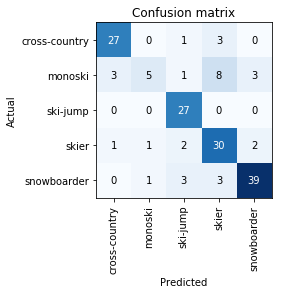

In [69]:
interpretation5_2 = ClassificationInterpretation.from_learner(learn5_2)

interpretation5_2.plot_confusion_matrix()

With no fine-tuning, we can observe than using the weights of the previous model improves a lot our classification, particularily when looking at the confusion between skiers and snowboarders. The classification of monoskiers is still bad but improving a little bit. Let's see we can get with some fine-tuning :

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


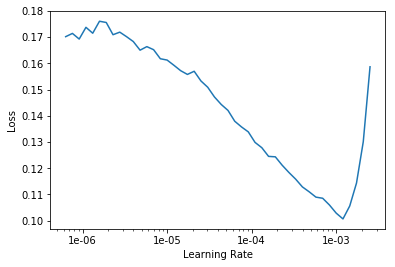

In [70]:
learn5_2.unfreeze()

learn5_2.lr_find()
learn5_2.recorder.plot()

In [71]:
learn5_2.fit_one_cycle(2, slice(1e-4))
learn5_2.save('multiclass-transfer-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.162723,0.557634,0.200000,00:33
1,0.132521,0.546174,0.193750,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


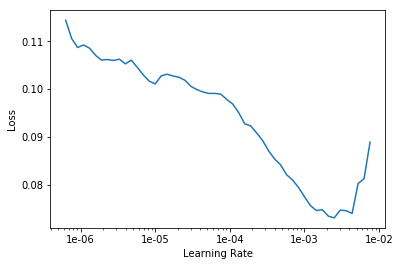

In [85]:
learn5_2.lr_find()
learn5_2.recorder.plot()

In [86]:
learn5_2.fit_one_cycle(2, slice(2e-4))
learn5_2.save('multiclass-transfer-3')

epoch,train_loss,valid_loss,error_rate,time
0,0.095018,0.540483,0.206250,00:34
1,0.075717,0.533198,0.206250,00:33


In [73]:
learn5_2.load('multiclass-transfer-2')

interp5_2 = ClassificationInterpretation.from_learner(learn5_2)

losses5_2,idxs5_2 = interp5_2.top_losses()

len(data5.valid_ds)==len(losses5_2)==len(idxs5_2)

True

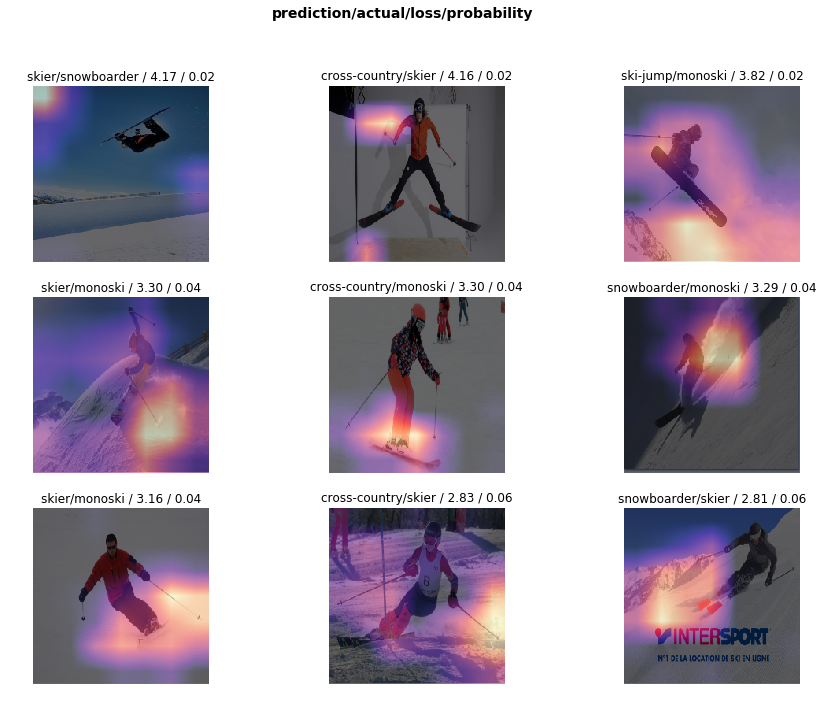

In [74]:
interp5_2.plot_top_losses(9, figsize=(15,11))

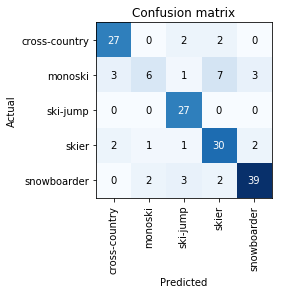

In [75]:
interp5_2.plot_confusion_matrix()

In [82]:
interp5_2.most_confused(min_val=3)

[('monoski', 'skier', 7),
 ('monoski', 'cross-country', 3),
 ('monoski', 'snowboarder', 3),
 ('snowboarder', 'ski-jump', 3)]

Our model gets a little better after some fine-tuning. It is still not that great at identifing monoskiers but it improved and it mixes them up with skiers most of the time, which is an honest mistake, even for an human observator (especially when the skis of monoski are hidden by the snow). The confusion between skiers and snowboarders has almost disappeared so our intuition that the knowledge aquired from our first model could be useful was correct.

In [0]:
learn5_2.export('wintersports-multiclass-model')

## Conclusion

Fast AI is a great tool for deep learning that allowed us to classify images of people practicing wintersports very accuratly and with minimum effort using a dataset that we created by hand. We noticed that the knowledge aquired from an easy classification task could be useful for an harder but similar classification task. 

## Production

Our model was put in production on [this](https://wintersportidentifier.onrender.com) website using the template available [here](https://github.com/render-examples/fastai-v3). Thanks a lot to the people at Fast.ai for making such usuful ressources available to everybody.